## MobilenetV2

Loading classification model from: model/mobilenet-v2.h5


Classification model loaded successfully.
Loading CSV from: output1.csv

Bắt đầu dự đoán trên 156 ảnh (đã crop sẵn). Ảnh đã xử lý sẽ được lưu vào 'mobilenetv2_precropped_evaluation_output_with_images1\processed_images'
Ảnh: 20250307_222838_031.jpg - True: look_away, Predicted: look_away (Time: 1.2783s)
Ảnh: 20250307_222838_032.jpg - True: look_away, Predicted: look_away (Time: 0.1202s)
Ảnh: 20250307_222838_033.jpg - True: look_away, Predicted: look_away (Time: 0.1168s)
Ảnh: 20250307_222838_034.jpg - True: look_away, Predicted: look_away (Time: 0.1028s)
Ảnh: 20250307_222838_035.jpg - True: look_away, Predicted: look_away (Time: 0.0996s)
Ảnh: 20250307_222838_036.jpg - True: look_away, Predicted: look_away (Time: 0.1037s)
Ảnh: 20250307_222838_037.jpg - True: look_away, Predicted: look_away (Time: 0.0981s)
Ảnh: 20250307_222838_039.jpg - True: look_away, Predicted: look_away (Time: 0.0960s)
Ảnh: 20250307_222838_040.jpg - True: look_away, Predicted: look_away (Time: 0.1097s)
Ảnh: 20250307_22

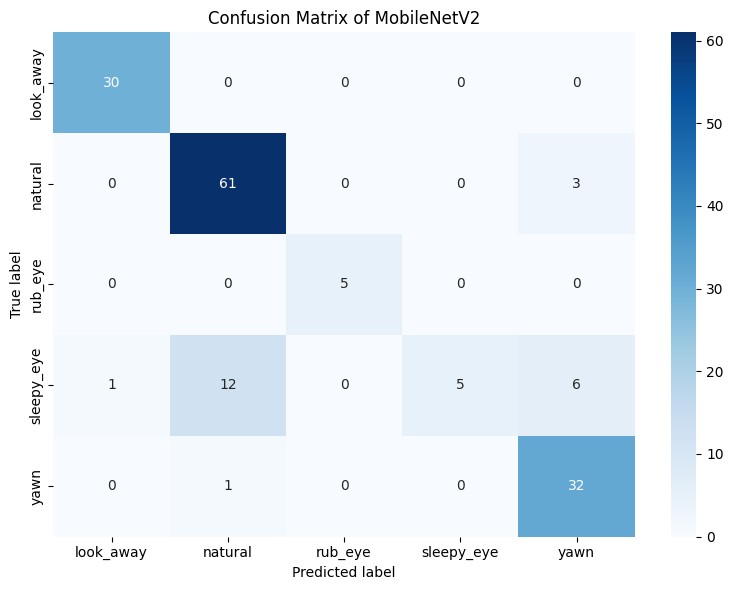

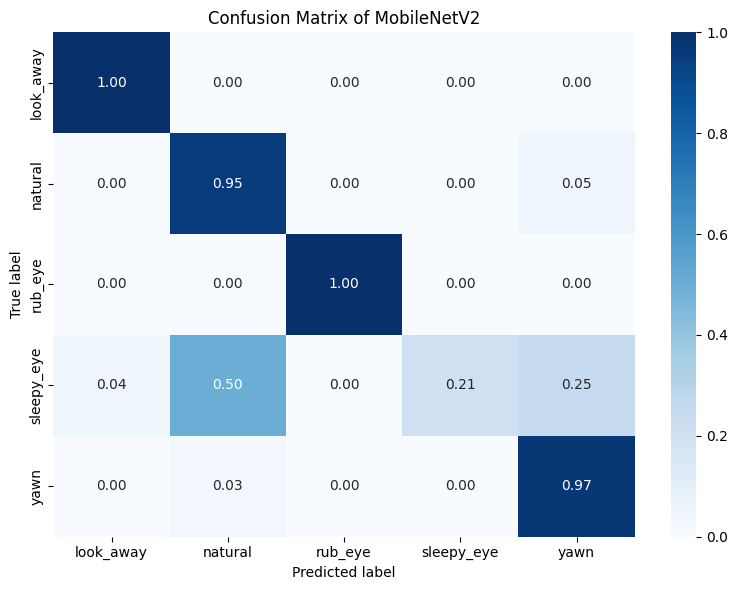

In [26]:
import pandas as pd
import time
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# --- CẤU HÌNH ---
MODEL_PATH = "model/mobilenet-v2.h5"
CSV_PATH = "output1.csv" # File CSV chứa đường dẫn đến các ảnh ĐÃ ĐƯỢC CROP
IMAGE_BASE_DIR = "" # Để trống nếu đường dẫn trong CSV là tuyệt đối hoặc tương đối với thư mục script
OUTPUT_DIR = "mobilenetv2_precropped_evaluation_output_with_images1"
PROCESSED_IMAGES_SUBDIR = "processed_images" # Thư mục con để lưu ảnh đã vẽ
INPUT_SHAPE = (224, 224) # Kích thước đầu vào mà model MobileNetV2 mong đợi

CLASS_LABELS = ['natural', 'sleepy_eye', 'yawn', 'rub_eye', 'look_away']

# --- HÀM HỖ TRỢ ---
def preprocess_image_for_mobilenet(image_bgr, target_size=(224, 224)):
    """
    Tiền xử lý ảnh (đã crop) cho MobileNetV2.
    Input là ảnh BGR đọc từ cv2.imread.
    """
    if image_bgr is None or image_bgr.size == 0:
        print("Lỗi: Ảnh đầu vào cho tiền xử lý rỗng hoặc không hợp lệ.")
        return None
    
    # MobileNetV2 thường được huấn luyện với ảnh RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, target_size)
    image_normalized = image_resized / 255.0
    image_normalized = image_normalized.astype(np.float32)
    image_batch = np.expand_dims(image_normalized, axis=0) # Thêm batch dimension
    return image_batch

def get_predicted_label_mobilenet(probabilities, class_labels_ordered):
    """
    Trích xuất nhãn dự đoán từ vector xác suất của MobileNetV2.
    Chọn nhãn có xác suất cao nhất.
    """
    
    highest_prob_idx = np.argmax(probabilities)
    predicted_label_str = class_labels_ordered[highest_prob_idx]
    return predicted_label_str

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, output_path="confusion_matrix.png"):
    if normalize:
        # Tránh chia cho 0 nếu một hàng toàn là 0 (không có mẫu nào của lớp đó)
        cm_sum = cm.sum(axis=1)[:, np.newaxis]
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_normalized = np.where(cm_sum > 0, cm.astype('float') / cm_sum, 0)
        cm = cm_normalized # Gán lại cm sau khi chuẩn hóa an toàn
        
    plt.figure(figsize=(max(8, int(len(classes)*0.8) ), max(6, int(len(classes) * 0.6))))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(output_path)
    print(f"Confusion matrix saved to {output_path}")

# --- CHƯƠNG TRÌNH CHÍNH ---
def main():
    output_dir_path = Path(OUTPUT_DIR)
    processed_images_path = output_dir_path / PROCESSED_IMAGES_SUBDIR
    output_dir_path.mkdir(parents=True, exist_ok=True)
    processed_images_path.mkdir(parents=True, exist_ok=True)

    print(f"Loading classification model from: {MODEL_PATH}")
    if not os.path.exists(MODEL_PATH):
        print(f"LỖI: Model phân loại không tìm thấy tại: {MODEL_PATH}")
        return
    try:
        classification_model = load_model(MODEL_PATH)
        print("Classification model loaded successfully.")
    except Exception as e:
        print(f"LỖI: Không thể tải model phân loại: {e}")
        return

    print(f"Loading CSV from: {CSV_PATH}")
    if not os.path.exists(CSV_PATH):
        print(f"LỖI: CSV file không tìm thấy tại: {CSV_PATH}")
        return
    df = pd.read_csv(CSV_PATH)

    true_labels_list = []
    predicted_labels_list = []
    inference_times_total = []

    print(f"\nBắt đầu dự đoán trên {len(df)} ảnh (đã crop sẵn). Ảnh đã xử lý sẽ được lưu vào '{processed_images_path}'")

    for index, row in df.iterrows():
        image_path_relative = row['original_file_path']
        true_label = row['labels'] # Nhãn thật từ CSV
        image_filename = Path(image_path_relative).name

        # Xử lý đường dẫn ảnh
        if IMAGE_BASE_DIR:
            base = Path(IMAGE_BASE_DIR)
            if not base.is_absolute(): base = Path.cwd() / base
            image_path_full_obj = base / image_path_relative
        else:
            image_path_full_obj = Path(image_path_relative)
            if not image_path_full_obj.is_absolute(): image_path_full_obj = Path.cwd() / image_path_full_obj
        image_path_full = str(image_path_full_obj.resolve())

        # Đọc ảnh (đã được crop)
        cropped_image_from_file = cv2.imread(image_path_full)
        
        predicted_label_for_image = ""
        output_image_to_save = None

        if cropped_image_from_file is None:
            print(f"CẢNH BÁO: Ảnh (đã crop) không tải được: {image_path_full}. Bỏ qua.")
            continue
        
        output_image_to_save = cropped_image_from_file.copy() # Ảnh này đã được crop
        start_time_total = time.time()

        # Tiền xử lý ảnh đã crop
        image_batch = preprocess_image_for_mobilenet(cropped_image_from_file, target_size=INPUT_SHAPE)
        
        if image_batch is not None:
            try:
                # Dự đoán bằng MobileNetV2
                predictions_proba = classification_model.predict(image_batch, verbose=0)[0]
                predicted_label_for_image = get_predicted_label_mobilenet(predictions_proba, CLASS_LABELS)
            except Exception as e:
                print(f"Lỗi khi dự đoán ảnh {image_filename} bằng model: {e}")
        else:
            print(f"Lỗi tiền xử lý ảnh (đã crop) cho: {image_filename}")

        end_time_total = time.time()
        inference_times_total.append(end_time_total - start_time_total)

        true_labels_list.append(true_label)
        predicted_labels_list.append(predicted_label_for_image)

        # Vẽ thông tin lên ảnh (đã crop)
        text_to_draw = f"Pred: {predicted_label_for_image}"
        true_text_to_draw = f"True: {true_label}"
        
        text_color = (0, 255, 0) # Xanh lá cho dự đoán đúng

        # Vì ảnh đã crop, vị trí vẽ text có thể cần điều chỉnh
        text_y_position = 30
        if output_image_to_save.shape[0] < 60: # Nếu ảnh quá nhỏ
            text_y_position = output_image_to_save.shape[0] // 4

        cv2.putText(output_image_to_save, text_to_draw, (10, text_y_position), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
        cv2.putText(output_image_to_save, true_text_to_draw, (10, output_image_to_save.shape[0] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2) # Xanh dương cho nhãn thật

        # Lưu ảnh đã vẽ
        save_path = processed_images_path / image_filename
        try:
            cv2.imwrite(str(save_path), output_image_to_save)
        except Exception as e:
            print(f"Lỗi khi lưu ảnh {save_path}: {e}")

        print(f"Ảnh: {image_filename} - True: {true_label}, Predicted: {predicted_label_for_image} (Time: {end_time_total - start_time_total:.4f}s)")

    # 3. Tính toán và lưu trữ kết quả
    if not true_labels_list or not predicted_labels_list:
        print("Không có dự đoán nào được thực hiện. Kết thúc.")
        return

    print("\n--- KẾT QUẢ ĐÁNH GIÁ (MobileNetV2 trên ảnh đã crop sẵn) ---")

    # Bao gồm tất cả các nhãn từ CSV, model và các nhãn lỗi có thể có
    cm_labels_ordered = sorted(list(set(true_labels_list + predicted_labels_list + CLASS_LABELS)))
    
    cm = confusion_matrix(true_labels_list, predicted_labels_list, labels=cm_labels_ordered)
    accuracy = accuracy_score(true_labels_list, predicted_labels_list)
    
    # Labels để báo cáo chi tiết (thường là các lớp model được huấn luyện)
    meaningful_labels_for_report = sorted(list(set(CLASS_LABELS).intersection(set(cm_labels_ordered))))
    
    if not meaningful_labels_for_report: # Nếu không có nhãn nào chung để báo cáo
        report_str = "Không có lớp chung giữa nhãn thật và dự đoán trong CLASS_LABELS để tạo báo cáo."
        print(report_str)
    else:
        report_str = classification_report(true_labels_list, predicted_labels_list, labels=meaningful_labels_for_report, zero_division=0, target_names=meaningful_labels_for_report)
    
    # Labels để tính F1 (chỉ các lớp chính, không tính lỗi)
    f1_labels_strict = meaningful_labels_for_report[:] # Sử dụng các nhãn đã lọc ở trên
    
    if not f1_labels_strict:
        f1_macro = 0.0
        f1_weighted = 0.0
        print("Cảnh báo: Không có nhãn phù hợp để tính F1 score chi tiết.")
    else:
        f1_macro = f1_score(true_labels_list, predicted_labels_list, average='macro', labels=f1_labels_strict, zero_division=0)
        f1_weighted = f1_score(true_labels_list, predicted_labels_list, average='weighted', labels=f1_labels_strict, zero_division=0)

    avg_inference_time = sum(inference_times_total) / len(inference_times_total) if inference_times_total else 0
    total_inference_time = sum(inference_times_total)

    print(f"Số lượng ảnh đã xử lý: {len(true_labels_list)}")
    print(f"Thời gian xử lý trung bình mỗi ảnh (Classification): {avg_inference_time:.4f} giây")
    print(f"Tổng thời gian xử lý: {total_inference_time:.4f} giây")
    print(f"Accuracy (tổng thể): {accuracy:.4f}")
    print(f"F1 Score (Macro, trên các lớp chính {f1_labels_strict}): {f1_macro:.4f}")
    print(f"F1 Score (Weighted, trên các lớp chính {f1_labels_strict}): {f1_weighted:.4f}")
    
    print("\nConfusion Matrix (Tổng thể):")
    cm_df = pd.DataFrame(cm, index=cm_labels_ordered, columns=cm_labels_ordered)
    print(cm_df)

    print(f"\nClassification Report (trên các lớp {meaningful_labels_for_report}):")
    print(report_str)

    results_summary_path = output_dir_path / "evaluation_summary_mobilenet_precropped.txt"
    with open(results_summary_path, "w", encoding="utf-8") as f:
        f.write("--- KẾT QUẢ ĐÁNH GIÁ MODEL MOBILENETV2 (trên ảnh đã crop sẵn) ---\n")
        f.write(f"Model Path: {MODEL_PATH}\n")
        f.write(f"CSV Path: {CSV_PATH}\n")
        f.write(f"Input Shape (của ảnh đã crop): {INPUT_SHAPE}\n")
        f.write(f"Class Labels (Model): {CLASS_LABELS}\n")
        f.write(f"Thư mục ảnh đã xử lý: {processed_images_path}\n")
        f.write(f"Số lượng ảnh đã xử lý: {len(true_labels_list)}\n")
        f.write(f"Thời gian xử lý trung bình mỗi ảnh: {avg_inference_time:.4f} giây\n")
        f.write(f"Tổng thời gian xử lý: {total_inference_time:.4f} giây\n")
        f.write(f"Accuracy (tổng thể): {accuracy:.4f}\n")
        f.write(f"F1 Score (Macro, trên các lớp chính {f1_labels_strict}): {f1_macro:.4f}\n")
        f.write(f"F1 Score (Weighted, trên các lớp chính {f1_labels_strict}): {f1_weighted:.4f}\n\n")
        f.write("Confusion Matrix (Tổng thể):\n")
        f.write(cm_df.to_string() + "\n\n")
        f.write(f"Classification Report (trên các lớp {meaningful_labels_for_report}):\n")
        f.write(report_str + "\n")
    print(f"\nKết quả tóm tắt đã được lưu vào: {results_summary_path}")

    cm_plot_path = output_dir_path / "confusion_matrix_mobilenet_precropped.png"
    plot_confusion_matrix(cm, classes=cm_labels_ordered, title='Confusion Matrix of MobileNetV2', output_path=str(cm_plot_path))

    cm_norm_plot_path = output_dir_path / "confusion_matrix_mobilenet_precropped_normalized.png"
    plot_confusion_matrix(cm, classes=cm_labels_ordered, normalize=True, title='Confusion Matrix of MobileNetV2', output_path=str(cm_norm_plot_path))

    print(f"\nĐã hoàn thành. Kết quả và ảnh đã xử lý được lưu trong thư mục '{output_dir_path}'.")

if __name__ == '__main__':
    # Không cần kiểm tra MediaPipe nữa
    if 'cv2' not in globals() or 'load_model' not in globals():
        print("Lỗi: Thiếu thư viện OpenCV hoặc TensorFlow/Keras.")
        print("Vui lòng cài đặt: pip install opencv-python tensorflow pandas scikit-learn matplotlib seaborn")

    else:
        main()

## CNN


Loading classification model from: model/custom_cnn_sleepiness_model.h5


Classification model loaded successfully.
Loading CSV from: output.csv

Bắt đầu dự đoán trên 156 ảnh (đã crop sẵn). Ảnh đã xử lý sẽ được lưu vào 'cnn_precropped_evaluation_output_with_images1\processed_images'
Ảnh: 20250307_222838_031.jpg - True: look_away, Predicted: look_away (Time: 0.2424s)
Ảnh: 20250307_222838_032.jpg - True: look_away, Predicted: look_away (Time: 0.1002s)
Ảnh: 20250307_222838_033.jpg - True: look_away, Predicted: look_away (Time: 0.0923s)
Ảnh: 20250307_222838_034.jpg - True: look_away, Predicted: look_away (Time: 0.0978s)
Ảnh: 20250307_222838_035.jpg - True: look_away, Predicted: look_away (Time: 0.0960s)
Ảnh: 20250307_222838_036.jpg - True: look_away, Predicted: look_away (Time: 0.1061s)
Ảnh: 20250307_222838_037.jpg - True: look_away, Predicted: look_away (Time: 0.0985s)
Ảnh: 20250307_222838_039.jpg - True: look_away, Predicted: look_away (Time: 0.2936s)
Ảnh: 20250307_222838_040.jpg - True: look_away, Predicted: look_away (Time: 0.1655s)
Ảnh: 20250307_222838_041.

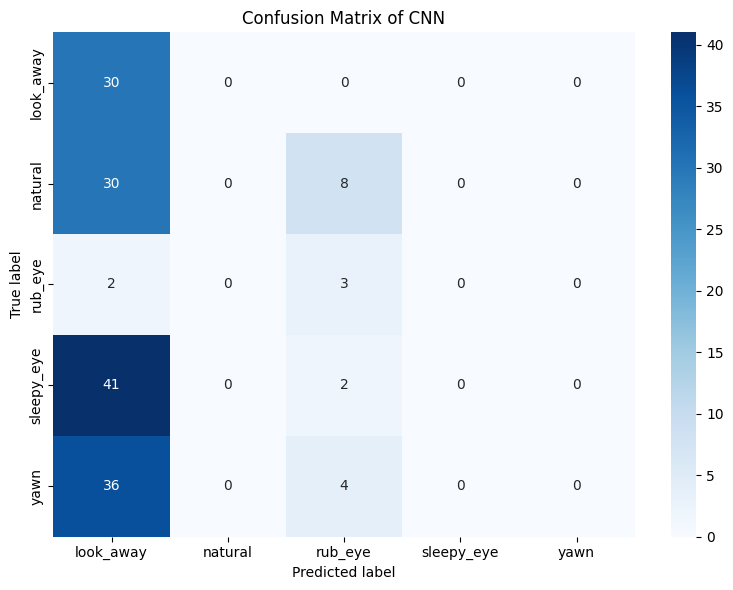

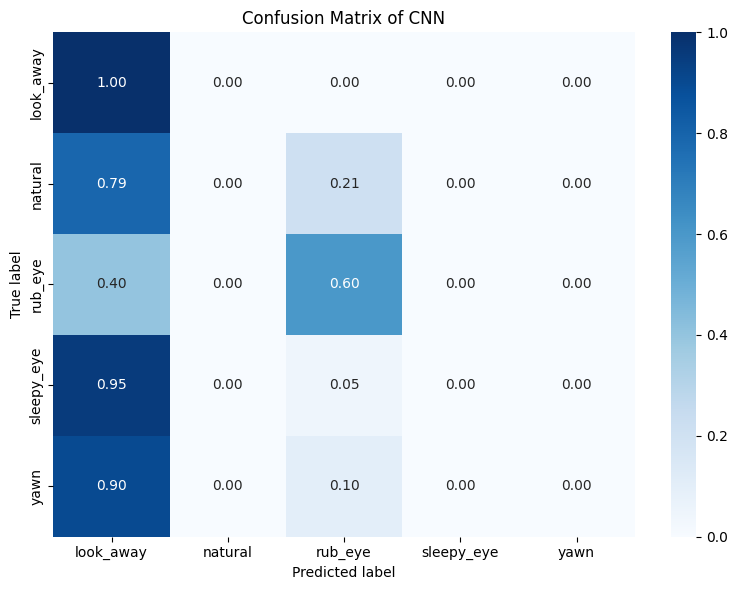

In [25]:
import pandas as pd
import time
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# --- CẤU HÌNH ---
MODEL_PATH = "model/custom_cnn_sleepiness_model.h5"
CSV_PATH = "output.csv" # File CSV chứa đường dẫn đến các ảnh ĐÃ ĐƯỢC CROP
IMAGE_BASE_DIR = "" # Để trống nếu đường dẫn trong CSV là tuyệt đối hoặc tương đối với thư mục script
OUTPUT_DIR = "cnn_precropped_evaluation_output_with_images1"
PROCESSED_IMAGES_SUBDIR = "processed_images" # Thư mục con để lưu ảnh đã vẽ
INPUT_SHAPE = (224, 224) # Kích thước đầu vào mà model CNN mong đợi

CLASS_LABELS = ['natural', 'sleepy_eye', 'yawn', 'rub_eye', 'look_away']

# --- HÀM HỖ TRỢ ---
def preprocess_image_for_mobilenet(image_bgr, target_size=(224, 224)):
    """
    Tiền xử lý ảnh (đã crop) cho CNN.
    Input là ảnh BGR đọc từ cv2.imread.
    """
    if image_bgr is None or image_bgr.size == 0:
        print("Lỗi: Ảnh đầu vào cho tiền xử lý rỗng hoặc không hợp lệ.")
        return None
    
    # CNN thường được huấn luyện với ảnh RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, target_size)
    image_normalized = image_resized / 255.0
    image_normalized = image_normalized.astype(np.float32)
    image_batch = np.expand_dims(image_normalized, axis=0) # Thêm batch dimension
    return image_batch

def get_predicted_label_mobilenet(probabilities, class_labels_ordered):
    """
    Trích xuất nhãn dự đoán từ vector xác suất của CNN.
    Chọn nhãn có xác suất cao nhất.
    """
    
    highest_prob_idx = np.argmax(probabilities)
    predicted_label_str = class_labels_ordered[highest_prob_idx]
    return predicted_label_str

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, output_path="confusion_matrix.png"):
    if normalize:
        # Tránh chia cho 0 nếu một hàng toàn là 0 (không có mẫu nào của lớp đó)
        cm_sum = cm.sum(axis=1)[:, np.newaxis]
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_normalized = np.where(cm_sum > 0, cm.astype('float') / cm_sum, 0)
        cm = cm_normalized # Gán lại cm sau khi chuẩn hóa an toàn
        
    plt.figure(figsize=(max(8, int(len(classes)*0.8) ), max(6, int(len(classes) * 0.6))))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(output_path)
    print(f"Confusion matrix saved to {output_path}")

# --- CHƯƠNG TRÌNH CHÍNH ---
def main():
    output_dir_path = Path(OUTPUT_DIR)
    processed_images_path = output_dir_path / PROCESSED_IMAGES_SUBDIR
    output_dir_path.mkdir(parents=True, exist_ok=True)
    processed_images_path.mkdir(parents=True, exist_ok=True)

    print(f"Loading classification model from: {MODEL_PATH}")
    if not os.path.exists(MODEL_PATH):
        print(f"LỖI: Model phân loại không tìm thấy tại: {MODEL_PATH}")
        return
    try:
        classification_model = load_model(MODEL_PATH)
        print("Classification model loaded successfully.")
    except Exception as e:
        print(f"LỖI: Không thể tải model phân loại: {e}")
        return

    print(f"Loading CSV from: {CSV_PATH}")
    if not os.path.exists(CSV_PATH):
        print(f"LỖI: CSV file không tìm thấy tại: {CSV_PATH}")
        return
    df = pd.read_csv(CSV_PATH)

    true_labels_list = []
    predicted_labels_list = []
    inference_times_total = []

    print(f"\nBắt đầu dự đoán trên {len(df)} ảnh (đã crop sẵn). Ảnh đã xử lý sẽ được lưu vào '{processed_images_path}'")

    for index, row in df.iterrows():
        image_path_relative = row['original_file_path']
        true_label = row['labels'] # Nhãn thật từ CSV
        image_filename = Path(image_path_relative).name

        # Xử lý đường dẫn ảnh
        if IMAGE_BASE_DIR:
            base = Path(IMAGE_BASE_DIR)
            if not base.is_absolute(): base = Path.cwd() / base
            image_path_full_obj = base / image_path_relative
        else:
            image_path_full_obj = Path(image_path_relative)
            if not image_path_full_obj.is_absolute(): image_path_full_obj = Path.cwd() / image_path_full_obj
        image_path_full = str(image_path_full_obj.resolve())

        # Đọc ảnh (đã được crop)
        cropped_image_from_file = cv2.imread(image_path_full)
        
        predicted_label_for_image = ""
        output_image_to_save = None

        if cropped_image_from_file is None:
            print(f"CẢNH BÁO: Ảnh (đã crop) không tải được: {image_path_full}. Bỏ qua.")
            continue
        
        output_image_to_save = cropped_image_from_file.copy() # Ảnh này đã được crop
        start_time_total = time.time()

        # Tiền xử lý ảnh đã crop
        image_batch = preprocess_image_for_mobilenet(cropped_image_from_file, target_size=INPUT_SHAPE)
        
        if image_batch is not None:
            try:
                # Dự đoán bằng CNN
                predictions_proba = classification_model.predict(image_batch, verbose=0)[0]
                predicted_label_for_image = get_predicted_label_mobilenet(predictions_proba, CLASS_LABELS)
            except Exception as e:
                print(f"Lỗi khi dự đoán ảnh {image_filename} bằng model: {e}")
        else:
            print(f"Lỗi tiền xử lý ảnh (đã crop) cho: {image_filename}")

        end_time_total = time.time()
        inference_times_total.append(end_time_total - start_time_total)

        true_labels_list.append(true_label)
        predicted_labels_list.append(predicted_label_for_image)

        # Vẽ thông tin lên ảnh (đã crop)
        text_to_draw = f"Pred: {predicted_label_for_image}"
        true_text_to_draw = f"True: {true_label}"
        
        text_color = (0, 255, 0) # Xanh lá cho dự đoán đúng

        # Vì ảnh đã crop, vị trí vẽ text có thể cần điều chỉnh
        text_y_position = 30
        if output_image_to_save.shape[0] < 60: # Nếu ảnh quá nhỏ
            text_y_position = output_image_to_save.shape[0] // 4

        cv2.putText(output_image_to_save, text_to_draw, (10, text_y_position), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
        cv2.putText(output_image_to_save, true_text_to_draw, (10, output_image_to_save.shape[0] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2) # Xanh dương cho nhãn thật

        # Lưu ảnh đã vẽ
        save_path = processed_images_path / image_filename
        try:
            cv2.imwrite(str(save_path), output_image_to_save)
        except Exception as e:
            print(f"Lỗi khi lưu ảnh {save_path}: {e}")

        print(f"Ảnh: {image_filename} - True: {true_label}, Predicted: {predicted_label_for_image} (Time: {end_time_total - start_time_total:.4f}s)")

    # 3. Tính toán và lưu trữ kết quả
    if not true_labels_list or not predicted_labels_list:
        print("Không có dự đoán nào được thực hiện. Kết thúc.")
        return

    print("\n--- KẾT QUẢ ĐÁNH GIÁ (CNN trên ảnh đã crop sẵn) ---")

    # Bao gồm tất cả các nhãn từ CSV, model và các nhãn lỗi có thể có
    cm_labels_ordered = sorted(list(set(true_labels_list + predicted_labels_list + CLASS_LABELS)))
    
    cm = confusion_matrix(true_labels_list, predicted_labels_list, labels=cm_labels_ordered)
    accuracy = accuracy_score(true_labels_list, predicted_labels_list)
    
    # Labels để báo cáo chi tiết (thường là các lớp model được huấn luyện)
    meaningful_labels_for_report = sorted(list(set(CLASS_LABELS).intersection(set(cm_labels_ordered))))
    
    if not meaningful_labels_for_report: # Nếu không có nhãn nào chung để báo cáo
        report_str = "Không có lớp chung giữa nhãn thật và dự đoán trong CLASS_LABELS để tạo báo cáo."
        print(report_str)
    else:
        report_str = classification_report(true_labels_list, predicted_labels_list, labels=meaningful_labels_for_report, zero_division=0, target_names=meaningful_labels_for_report)
    
    # Labels để tính F1 (chỉ các lớp chính, không tính lỗi)
    f1_labels_strict = meaningful_labels_for_report[:] # Sử dụng các nhãn đã lọc ở trên
    
    if not f1_labels_strict:
        f1_macro = 0.0
        f1_weighted = 0.0
        print("Cảnh báo: Không có nhãn phù hợp để tính F1 score chi tiết.")
    else:
        f1_macro = f1_score(true_labels_list, predicted_labels_list, average='macro', labels=f1_labels_strict, zero_division=0)
        f1_weighted = f1_score(true_labels_list, predicted_labels_list, average='weighted', labels=f1_labels_strict, zero_division=0)

    avg_inference_time = sum(inference_times_total) / len(inference_times_total) if inference_times_total else 0
    total_inference_time = sum(inference_times_total)

    print(f"Số lượng ảnh đã xử lý: {len(true_labels_list)}")
    print(f"Thời gian xử lý trung bình mỗi ảnh (Classification): {avg_inference_time:.4f} giây")
    print(f"Tổng thời gian xử lý: {total_inference_time:.4f} giây")
    print(f"Accuracy (tổng thể): {accuracy:.4f}")
    print(f"F1 Score (Macro, trên các lớp chính {f1_labels_strict}): {f1_macro:.4f}")
    print(f"F1 Score (Weighted, trên các lớp chính {f1_labels_strict}): {f1_weighted:.4f}")
    
    print("\nConfusion Matrix (Tổng thể):")
    cm_df = pd.DataFrame(cm, index=cm_labels_ordered, columns=cm_labels_ordered)
    print(cm_df)

    print(f"\nClassification Report (trên các lớp {meaningful_labels_for_report}):")
    print(report_str)

    results_summary_path = output_dir_path / "evaluation_summary_mobilenet_precropped.txt"
    with open(results_summary_path, "w", encoding="utf-8") as f:
        f.write("--- KẾT QUẢ ĐÁNH GIÁ MODEL CNN (trên ảnh đã crop sẵn) ---\n")
        f.write(f"Model Path: {MODEL_PATH}\n")
        f.write(f"CSV Path: {CSV_PATH}\n")
        f.write(f"Input Shape (của ảnh đã crop): {INPUT_SHAPE}\n")
        f.write(f"Class Labels (Model): {CLASS_LABELS}\n")
        f.write(f"Thư mục ảnh đã xử lý: {processed_images_path}\n")
        f.write(f"Số lượng ảnh đã xử lý: {len(true_labels_list)}\n")
        f.write(f"Thời gian xử lý trung bình mỗi ảnh: {avg_inference_time:.4f} giây\n")
        f.write(f"Tổng thời gian xử lý: {total_inference_time:.4f} giây\n")
        f.write(f"Accuracy (tổng thể): {accuracy:.4f}\n")
        f.write(f"F1 Score (Macro, trên các lớp chính {f1_labels_strict}): {f1_macro:.4f}\n")
        f.write(f"F1 Score (Weighted, trên các lớp chính {f1_labels_strict}): {f1_weighted:.4f}\n\n")
        f.write("Confusion Matrix (Tổng thể):\n")
        f.write(cm_df.to_string() + "\n\n")
        f.write(f"Classification Report (trên các lớp {meaningful_labels_for_report}):\n")
        f.write(report_str + "\n")
    print(f"\nKết quả tóm tắt đã được lưu vào: {results_summary_path}")

    cm_plot_path = output_dir_path / "confusion_matrix_mobilenet_precropped.png"
    plot_confusion_matrix(cm, classes=cm_labels_ordered, title='Confusion Matrix of CNN', output_path=str(cm_plot_path))

    cm_norm_plot_path = output_dir_path / "confusion_matrix_mobilenet_precropped_normalized.png"
    plot_confusion_matrix(cm, classes=cm_labels_ordered, normalize=True, title='Confusion Matrix of CNN', output_path=str(cm_norm_plot_path))

    print(f"\nĐã hoàn thành. Kết quả và ảnh đã xử lý được lưu trong thư mục '{output_dir_path}'.")

if __name__ == '__main__':
    # Không cần kiểm tra MediaPipe nữa
    if 'cv2' not in globals() or 'load_model' not in globals():
        print("Lỗi: Thiếu thư viện OpenCV hoặc TensorFlow/Keras.")
        print("Vui lòng cài đặt: pip install opencv-python tensorflow pandas scikit-learn matplotlib seaborn")

    else:
        main()

## Crop


In [11]:
import cv2
import mediapipe as mp
import os
from pathlib import Path

# --- CẤU HÌNH ---
INPUT_IMAGE_ROOT_DIR = "test"  # THAY THẾ: Thư mục gốc chứa các thư mục con (class) với ảnh
OUTPUT_CROPPED_ROOT_DIR = "output_cropped_faces"          # THAY THẾ: Thư mục gốc để lưu các khuôn mặt đã cắt
MIN_DETECTION_CONFIDENCE = 0.5                            # Ngưỡng tin cậy cho phát hiện khuôn mặt
SAVE_ORIGINAL_IF_NO_FACE = False                          # True để copy ảnh gốc nếu không tìm thấy khuôn mặt

# --- KHỞI TẠO MEDIAPIPE FACE DETECTION ---
mp_face_detection = mp.solutions.face_detection
# model_selection=0: cho khoảng cách gần (dưới 2m)
# model_selection=1: cho khoảng cách xa hơn (lên đến 5m)
face_detector = mp_face_detection.FaceDetection(
    model_selection=0, min_detection_confidence=MIN_DETECTION_CONFIDENCE
)

def crop_and_save_faces(image_path_obj: Path, output_class_dir: Path, face_detector_instance):
    """
    Đọc ảnh, phát hiện khuôn mặt, cắt và lưu chúng.
    Trả về số lượng khuôn mặt được phát hiện và lưu.
    """
    try:
        image = cv2.imread(str(image_path_obj))
        if image is None:
            print(f"Lỗi: Không thể đọc ảnh: {image_path_obj}")
            return 0
    except Exception as e:
        print(f"Lỗi khi đọc ảnh {image_path_obj}: {e}")
        return 0

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detector_instance.process(image_rgb)

    faces_saved_count = 0
    if results.detections:
        for i, detection in enumerate(results.detections):
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = image.shape
            
            # Kiểm tra xem bboxC có tồn tại không
            if not bboxC:
                print(f"Cảnh báo: Không có relative_bounding_box cho detection {i} trong {image_path_obj.name}")
                continue

            x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                           int(bboxC.width * iw), int(bboxC.height * ih)

            # Đảm bảo tọa độ nằm trong ảnh và kích thước hợp lệ
            x_start, y_start = max(0, x), max(0, y)
            x_end, y_end = min(iw, x + w), min(ih, y + h)

            if x_end > x_start and y_end > y_start: # Kiểm tra crop hợp lệ
                cropped_face = image[y_start:y_end, x_start:x_end]
                
                # Tạo tên file cho ảnh crop
                original_filename_stem = image_path_obj.stem
                cropped_filename = f"{original_filename_stem}{image_path_obj.suffix}"
                output_path = output_class_dir / cropped_filename
                
                try:
                    cv2.imwrite(str(output_path), cropped_face)
                    faces_saved_count += 1
                except Exception as e:
                    print(f"Lỗi khi lưu ảnh crop {output_path}: {e}")
            else:
                print(f"Cảnh báo: Kích thước crop không hợp lệ cho {image_path_obj.name}, face {i}. Bỏ qua.")
    
    elif SAVE_ORIGINAL_IF_NO_FACE:
        # Nếu không có khuôn mặt nào được phát hiện và tùy chọn được bật
        output_path = output_class_dir / image_path_obj.name
        try:
            cv2.imwrite(str(output_path), image)
            print(f"Không tìm thấy khuôn mặt trong {image_path_obj.name}. Đã lưu ảnh gốc vào {output_path}")
        except Exception as e:
            print(f"Lỗi khi lưu ảnh gốc {output_path}: {e}")
            
    return faces_saved_count

def main():
    input_root = Path(INPUT_IMAGE_ROOT_DIR)
    output_root = Path(OUTPUT_CROPPED_ROOT_DIR)

    if not input_root.is_dir():
        print(f"LỖI: Thư mục đầu vào '{input_root}' không tồn tại hoặc không phải là thư mục.")
        return

    output_root.mkdir(parents=True, exist_ok=True)
    print(f"Khuôn mặt đã cắt sẽ được lưu vào: {output_root.resolve()}")

    total_images_processed = 0
    total_faces_cropped = 0

    # Duyệt qua các thư mục con (class) trong thư mục gốc đầu vào
    for class_dir in input_root.iterdir():
        if class_dir.is_dir():
            current_class_name = class_dir.name
            print(f"\nĐang xử lý lớp: {current_class_name}")

            # Tạo thư mục con tương ứng trong thư mục output
            output_class_dir_path = output_root / current_class_name
            output_class_dir_path.mkdir(parents=True, exist_ok=True)

            images_in_class = 0
            faces_in_class = 0

            # Duyệt qua các file ảnh trong thư mục lớp hiện tại
            for image_file in class_dir.glob('*'): # Lấy tất cả file
                if image_file.suffix.lower() in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']:
                    images_in_class += 1
                    total_images_processed += 1
                    print(f"  Đang xử lý ảnh: {image_file.name}")
                    
                    num_saved = crop_and_save_faces(image_file, output_class_dir_path, face_detector)
                    faces_in_class += num_saved
                    total_faces_cropped += num_saved
            
            print(f"  Hoàn thành lớp {current_class_name}: {images_in_class} ảnh đã xử lý, {faces_in_class} khuôn mặt đã cắt.")

    print("\n--- TÓM TẮT ---")
    print(f"Tổng số ảnh đã xử lý: {total_images_processed}")
    print(f"Tổng số khuôn mặt đã cắt và lưu: {total_faces_cropped}")
    print(f"Đã hoàn thành. Kiểm tra thư mục '{output_root.resolve()}'.")

if __name__ == "__main__":
    # Ví dụ cách tạo cấu trúc thư mục giả để test:
    # Path("test_input_images/class_A").mkdir(parents=True, exist_ok=True)
    # Path("test_input_images/class_B").mkdir(parents=True, exist_ok=True)
    # # Sau đó, bạn copy một vài ảnh vào thư mục test_input_images/class_A và test_input_images/class_B
    # # Rồi đặt INPUT_IMAGE_ROOT_DIR = "test_input_images"
    
    # Cần đảm bảo thư viện được import
    if 'cv2' not in globals() or 'mp' not in globals():
        print("Lỗi: Thiếu thư viện OpenCV hoặc MediaPipe.")
        print("Vui lòng cài đặt: pip install opencv-python mediapipe")
    else:
        main()

Khuôn mặt đã cắt sẽ được lưu vào: D:\Documents\Ki_8\XLA\yolov11_full_v3\output_cropped_faces

Đang xử lý lớp: look_away
  Đang xử lý ảnh: 20250307_222838_031.jpg
  Đang xử lý ảnh: 20250307_222838_032.jpg
  Đang xử lý ảnh: 20250307_222838_033.jpg
  Đang xử lý ảnh: 20250307_222838_034.jpg
  Đang xử lý ảnh: 20250307_222838_035.jpg
  Đang xử lý ảnh: 20250307_222838_036.jpg
  Đang xử lý ảnh: 20250307_222838_037.jpg
  Đang xử lý ảnh: 20250307_222838_039.jpg
  Đang xử lý ảnh: 20250307_222838_040.jpg
  Đang xử lý ảnh: 20250307_222838_041.jpg
  Đang xử lý ảnh: 20250307_222838_042.jpg
  Đang xử lý ảnh: 20250307_222838_043.jpg
  Đang xử lý ảnh: 20250307_222838_044.jpg
  Đang xử lý ảnh: 20250307_222838_045.jpg
  Đang xử lý ảnh: 20250307_222838_047.jpg
  Đang xử lý ảnh: 20250307_222838_048.jpg
  Đang xử lý ảnh: 20250307_222838_049.jpg
  Đang xử lý ảnh: 20250307_222838_050.jpg
  Đang xử lý ảnh: 20250307_222838_051.jpg
  Đang xử lý ảnh: 20250307_222838_052.jpg
  Đang xử lý ảnh: 20250307_222838_053.jp